In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Welcome to JupyROOT 6.20/04


In [2]:
##### setting file path #####

ttbarBG_rootpath = "/data/Chen-Wang/ttbarBG/Events/run_01/tag_1_delphes_events.root"
ttbarBG_file = uproot.open(ttbarBG_rootpath)

jjBG_rootpath = "/data/Chen-Wang/jjBG_200PT/Events/run_01/tag_1_delphes_events.root"
jjBG_file = uproot.open(jjBG_rootpath)

In [3]:
##### include ttbarBG data #####

ttbarBG_events = [ttbarBG_file["Delphes;1"]["Particle.Status"].array(),
        ttbarBG_file["Delphes;1"]["Particle.PT"].array(),
        ttbarBG_file["Delphes;1"]["Particle.Eta"].array(),
        ttbarBG_file["Delphes;1"]["Particle.Phi"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Particles"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Eta"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Phi"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.PT"].array(),
        ttbarBG_file["Delphes;1"]["FatJet"].array()
        ]

##### reshape the signal data #####

ttbarBG_events = np.expand_dims(ttbarBG_events, axis=-1)
ttbarBG_events = ttbarBG_events.transpose((1,0,2))
ttbarBG_events = np.squeeze(ttbarBG_events,axis=(2,))

##### include jjBG data #####

jjBG_events = [jjBG_file["Delphes;1"]["Particle.Status"].array(),
        jjBG_file["Delphes;1"]["Particle.PT"].array(),
        jjBG_file["Delphes;1"]["Particle.Eta"].array(),
        jjBG_file["Delphes;1"]["Particle.Phi"].array(),
        jjBG_file["Delphes;1"]["FatJet.Particles"].array(),
        jjBG_file["Delphes;1"]["FatJet.Eta"].array(),
        jjBG_file["Delphes;1"]["FatJet.Phi"].array(),
        jjBG_file["Delphes;1"]["FatJet.PT"].array(),
        jjBG_file["Delphes;1"]["FatJet"].array()
        ]

##### reshape the signal data #####

jjBG_events = np.expand_dims(jjBG_events, axis=-1)
jjBG_events = jjBG_events.transpose((1,0,2))
jjBG_events = np.squeeze(jjBG_events,axis=(2,))

In [4]:
#####   useful function    #####
##### select if Fat Jet>=2 #####

def Fat_Jet_selection(events):
    where1 = np.where(events[:,8]>=2)
    return events[where1]

##### define figure generator #####

def PT_generator(event):
    grid_num = 50    # means n^2 points
    where_jet_particle = event[4][0]+event[4][1]
    where_jet_particle = np.array(where_jet_particle)-1
    particle_Eta = event[2][where_jet_particle] - event[5][0]
    particle_Phi = event[3][where_jet_particle] - event[6][0]
    particle_PT = event[1][where_jet_particle]
    
    xedges = np.linspace(-5, 5, grid_num+1)        # Eta limit
    yedges = np.linspace(-5, 5, grid_num+1)    # Phi limit
    PT = np.zeros([grid_num,grid_num])
    
    for Eta in range(grid_num):
        for Phi in range(grid_num):
            where1 = np.where((xedges[Eta]<particle_Eta) & (particle_Eta<xedges[Eta+1]) & (yedges[Phi]<particle_Phi) & (particle_Phi<yedges[Phi+1]))
            PT[Eta][Phi] = sum(particle_PT[where1])
            
    return PT.T    ### after transpose: X=eta Y=phi

##### define leading jet generator #####

def leadingJ_generator(jet_events):
    grid_num = 50    # means n^2 points
    where_jet_particle = jet_events[4][0]
    where_jet_particle = np.array(where_jet_particle)-1
    particle_Eta = jet_events[2][where_jet_particle] - jet_events[5][0]    # do the centerize
    particle_Phi = jet_events[3][where_jet_particle] - jet_events[6][0]    # do the centerize
    particle_PT = jet_events[1][where_jet_particle]
    
    xedges = np.linspace(-1, 1, grid_num+1)    # Eta limit
    yedges = np.linspace(-1, 1, grid_num+1)    # Phi limit
    PT = np.zeros([grid_num,grid_num])
    
    for Eta in range(grid_num):
        for Phi in range(grid_num):
            where1 = np.where((xedges[Eta]<particle_Eta) & (particle_Eta<xedges[Eta+1]) & (yedges[Phi]<particle_Phi) & (particle_Phi<yedges[Phi+1]))
            PT[Eta][Phi] = sum(particle_PT[where1])
    
    leading_b = np.where(PT==np.max(PT))
    PT[leading_b[0][0]-4:leading_b[0][0]+4, leading_b[1][0]-4:leading_b[1][0]+4] = 0
    subleading_b = np.where(PT==np.max(PT))

    eta_diff = (subleading_b[0][0]-leading_b[0][0])*(1/grid_num)     # each grid different (1/grid_num)
    phi_diff = (subleading_b[1][0]-leading_b[1][0])*(1/grid_num)     # each grid different (1/grid_num)
    cos_theta = (0*eta_diff + -1*phi_diff)/np.sqrt(eta_diff**2 + phi_diff**2)     # inner product with (0,-1)
    sin_theta = np.sqrt(1-cos_theta**2) if eta_diff>0 else -np.sqrt(1-cos_theta**2)

    particle_Eta_rot = cos_theta*particle_Eta + sin_theta*particle_Phi
    particle_Phi_rot = -sin_theta*particle_Eta + cos_theta*particle_Phi

    for Eta_rot in range(grid_num):
        for Phi_rot in range(grid_num):
            where1 = np.where((xedges[Eta_rot]<particle_Eta_rot) & (particle_Eta_rot<xedges[Eta_rot+1]) & (yedges[Phi_rot]<particle_Phi_rot) & (particle_Phi_rot<yedges[Phi_rot+1]))
            PT[Eta_rot][Phi_rot] = sum(particle_PT[where1])
    
    return PT.T

##### define sub-leading jet generator #####

def subleadingJ_generator(jet_events):
    grid_num = 50    # means n^2 points
    where_jet_particle = jet_events[4][1]
    where_jet_particle = np.array(where_jet_particle)-1
    particle_Eta = jet_events[2][where_jet_particle] - jet_events[5][1]    # do the centerize
    particle_Phi = jet_events[3][where_jet_particle] - jet_events[6][1]    # do the centerize
    particle_PT = jet_events[1][where_jet_particle]
    
    xedges = np.linspace(-1, 1, grid_num+1)    # Eta limit
    yedges = np.linspace(-1, 1, grid_num+1)    # Phi limit
    PT = np.zeros([grid_num,grid_num])
    
    for Eta in range(grid_num):
        for Phi in range(grid_num):
            where1 = np.where((xedges[Eta]<particle_Eta) & (particle_Eta<xedges[Eta+1]) & (yedges[Phi]<particle_Phi) & (particle_Phi<yedges[Phi+1]))
            PT[Eta][Phi] = sum(particle_PT[where1])
    
    leading_b = np.where(PT==np.max(PT))
    PT[leading_b[0][0]-4:leading_b[0][0]+4, leading_b[1][0]-4:leading_b[1][0]+4] = 0
    subleading_b = np.where(PT==np.max(PT))

    eta_diff = (subleading_b[0][0]-leading_b[0][0])*(1/grid_num)     # each grid different (1/grid_num)
    phi_diff = (subleading_b[1][0]-leading_b[1][0])*(1/grid_num)     # each grid different (1/grid_num)
    cos_theta = (0*eta_diff + -1*phi_diff)/np.sqrt(eta_diff**2 + phi_diff**2)     # inner product with (0,-1)
    sin_theta = np.sqrt(1-cos_theta**2) if eta_diff>0 else -np.sqrt(1-cos_theta**2)

    particle_Eta_rot = cos_theta*particle_Eta + sin_theta*particle_Phi
    particle_Phi_rot = -sin_theta*particle_Eta + cos_theta*particle_Phi

    for Eta_rot in range(grid_num):
        for Phi_rot in range(grid_num):
            where1 = np.where((xedges[Eta_rot]<particle_Eta_rot) & (particle_Eta_rot<xedges[Eta_rot+1]) & (yedges[Phi_rot]<particle_Phi_rot) & (particle_Phi_rot<yedges[Phi_rot+1]))
            PT[Eta_rot][Phi_rot] = sum(particle_PT[where1])
    
    return PT.T

In [5]:
ttbarBG_events = Fat_Jet_selection(ttbarBG_events)
print("There are", len(ttbarBG_events), "ttbarBG events survive with originally 10000 events.")

jjBG_events = Fat_Jet_selection(jjBG_events)
print("There are", len(jjBG_events), "jjBG events survive with originally 10000 events.")

There are 6160 ttbarBG events survive with originally 10000 events.
There are 6172 jjBG events survive with originally 10000 events.


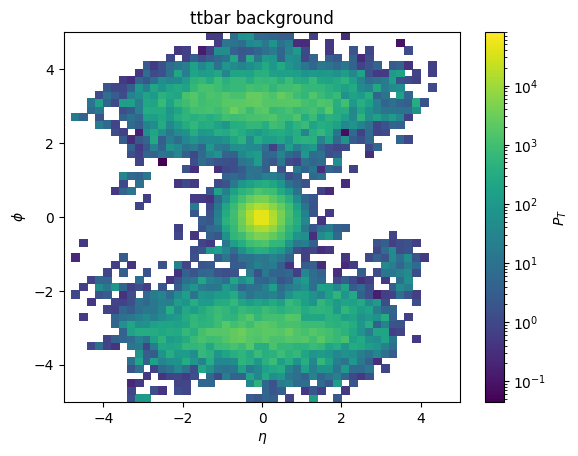

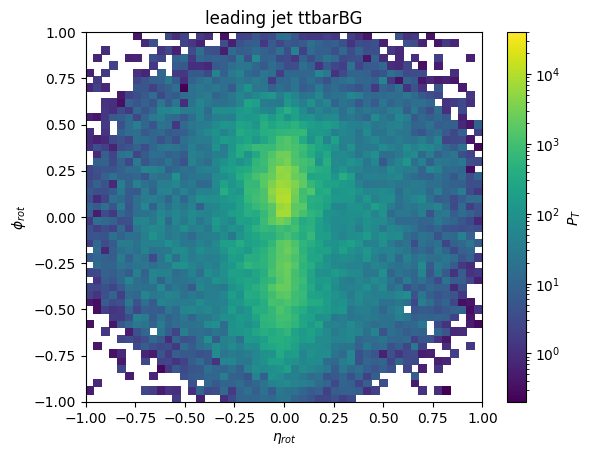

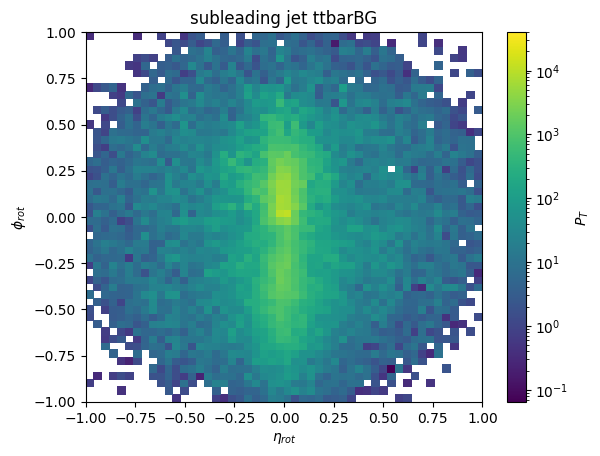

In [6]:
grid_num = 50    # means n^2 points
events_num = 1000
xedges = np.linspace(-5, 5, grid_num+1)    # Eta limit
yedges = np.linspace(-5, 5, grid_num+1)    # Phi limit

ttbarBG_PT_figure_total = np.zeros([grid_num,grid_num])
for i in range(events_num):
    ttbarBG_PT_figure_total = ttbarBG_PT_figure_total + PT_generator(ttbarBG_events[i])

pcm = plt.pcolormesh(xedges, yedges, ttbarBG_PT_figure_total, norm=LogNorm(vmax=8*10**4))
plt.colorbar(pcm, label='$P_T$')
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("ttbar background")
plt.show()

##### plot leading jet image #####

jet_xedges = np.linspace(-1, 1, grid_num+1)    # Eta limit
jet_yedges = np.linspace(-1, 1, grid_num+1)    # Phi limit

ttbarBG_leading_total = np.zeros([grid_num,grid_num])
for i in range(events_num):
    ttbarBG_leading_total = ttbarBG_leading_total + leadingJ_generator(ttbarBG_events[i])

pcm = plt.pcolormesh(jet_xedges, jet_yedges, ttbarBG_leading_total, norm=LogNorm(vmax=4*10**4))
plt.colorbar(pcm, label='$P_T$')
plt.xlabel("$\eta_{rot}$")
plt.ylabel("$\phi_{rot}$")
plt.title("leading jet ttbarBG")
plt.show()

##### plot sub-leading jet image #####

ttbarBG_subleading_total = np.zeros([grid_num,grid_num])
for i in range(events_num):
    ttbarBG_subleading_total = ttbarBG_subleading_total + subleadingJ_generator(ttbarBG_events[i])

pcm = plt.pcolormesh(jet_xedges, jet_yedges, ttbarBG_subleading_total, norm=LogNorm(vmax=4*10**4))
plt.colorbar(pcm, label='$P_T$')
plt.xlabel("$\eta_{rot}$")
plt.ylabel("$\phi_{rot}$")
plt.title("subleading jet ttbarBG")
plt.show()

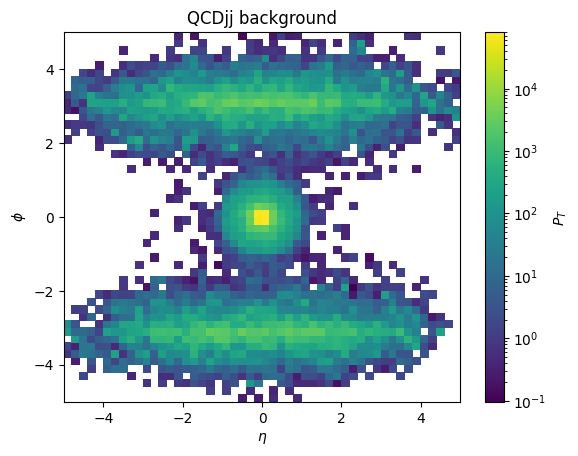

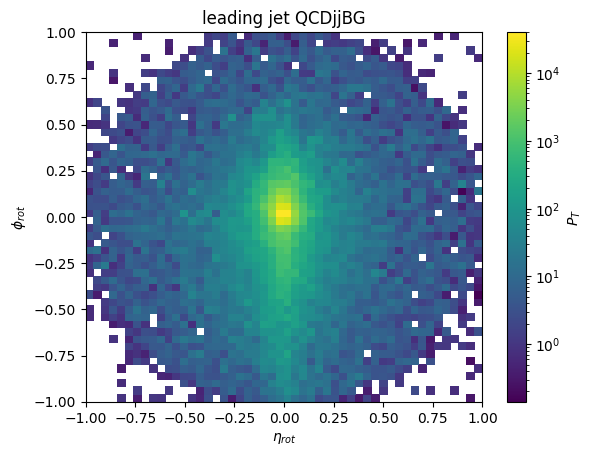

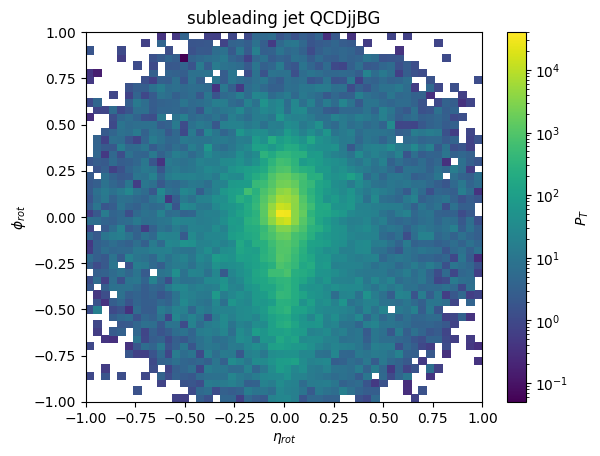

In [7]:
grid_num = 50    # means n^2 points
xedges = np.linspace(-5, 5, grid_num+1)    # Eta limit
yedges = np.linspace(-5, 5, grid_num+1)    # Phi limit

jjBG_PT_figure_total = np.zeros([grid_num,grid_num])
for i in range(1000):
    jjBG_PT_figure_total = jjBG_PT_figure_total + PT_generator(jjBG_events[i])

pcm = plt.pcolormesh(xedges, yedges, jjBG_PT_figure_total, norm=LogNorm(vmax=8*10**4))
plt.colorbar(pcm, label='$P_T$')
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("QCDjj background")
plt.show()

##### plot leading jet image #####

jet_xedges = np.linspace(-1, 1, grid_num+1)    # Eta limit
jet_yedges = np.linspace(-1, 1, grid_num+1)    # Phi limit

jjBG_leading_total = np.zeros([grid_num,grid_num])
for i in range(events_num):
    jjBG_leading_total = jjBG_leading_total + leadingJ_generator(jjBG_events[i])

pcm = plt.pcolormesh(jet_xedges, jet_yedges, jjBG_leading_total, norm=LogNorm(vmax=4*10**4))
plt.colorbar(pcm, label='$P_T$')
plt.xlabel("$\eta_{rot}$")
plt.ylabel("$\phi_{rot}$")
plt.title("leading jet QCDjjBG")
plt.show()

##### plot sub-leading jet image #####

jjBG_subleading_total = np.zeros([grid_num,grid_num])
for i in range(events_num):
    jjBG_subleading_total = jjBG_subleading_total + subleadingJ_generator(jjBG_events[i])

pcm = plt.pcolormesh(jet_xedges, jet_yedges, jjBG_subleading_total, norm=LogNorm(vmax=4*10**4))
plt.colorbar(pcm, label='$P_T$')
plt.xlabel("$\eta_{rot}$")
plt.ylabel("$\phi_{rot}$")
plt.title("subleading jet QCDjjBG")
plt.show()